# **Simulation of Genetic Circuits from DPAHelix project**

> **Objective**: Simulate the behavior of genetic circuits in engineered _B. subtilis_.

We set a mathematical model of the SpoVF genetic circuit in engineered Bacillus subtilis to simulate the critical aspects from DNA transcription to DPA (dipicolinic acid) product synthesis. We analyze transcriptional kinetics, translation dynamics, enzyme catalysis, and product accumulation across four constitutive promoters (p43, pylb, pyddf, pmsm) under varying metabolic conditions. We identify:

1. Promoter ranking
2. Temporal dynamics of mRNA and protein accumulation
3. Enzyme activity
4. DPA titers approximation

## **1. Install and import libraries**

In [27]:
#%%capture
#!pip install numpy scipy matplotlib

In [28]:
import numpy as np
from scipy.integrate import cumulative_trapezoid, odeint
import matplotlib.pyplot as plt

## **2. Promoter transcription rate prediction**

The mRNA concentration over time is modeled using an Ordinary Differential Equation (ODE) that balances the rate of transcript synthesis and first-order degradation, derived from [^1]:

$$
\frac{dm}{dt} = \underbrace{\left(\alpha \cdot \text{Tx}_{\text{rate}} \cdot c \cdot \frac{V_i}{K_d + V_i} \right)}_{\text{Production Rate } (P)} \;-\; \underbrace{d_1 \cdot m}_{\text{Degradation Rate } (D)}
$$

where:

- $m$: mRNA concentration (M)
- $\alpha$: Molarity per molecule per cell (M molecule⁻¹)
- $\text{Tx}_{rate}$: Transcription completion rate per DNA template (transcripts s⁻¹)
- $c$: Plasmid or genomic copy number (dimensionless)
- $V_i$: Inducer concentration (M)
- $K_d$: Dissociation constant of the inducer (M)
- $d_1$: mRNA degradation rate (s⁻¹)

The production term, $P$, incorporates a Hill-like kinetic model to capture the response of the promoter to the inducer concentration, $V_i$. By scaling the transcription completion frequency ($\text{Tx}_{rate}$) by the molarity constant ($\alpha$) and the gene copy number ($c$), the term represents the total molar rate of mRNA synthesis across all available DNA templates. On the other hand, $D$ represents the first-order degradation of the mRNA transcripts by cellular ribonucleases (RNases), implying that the rate of decay is directly proportional to the current mRNA concentration ($m$).

In steady-state conditions, where $\frac{dm}{dt} = 0$, the production rate $P$ is exactly balanced by the degradation rate $D$, allowing for the determination of the equilibrium transcript level as $m^* = \frac{P}{d_1}$.

For constitutive expression, the equation is simplified by assuming the promoter operates at its maximum capacity ($V_i \gg K_d$):

$$\frac{dm}{dt} = \underbrace{\alpha \cdot \text{Tx}_{\text{rate}} \cdot c}_{\text{Production Rate } (P)} \;-\; \underbrace{d_1 \cdot m}_{\text{Degradation Rate } (D)}$$

---

### **Mechanistic Transcription Model**

The transcription process consists of two sequential steps:

1. **Initiation**: RNA polymerase (RNAP) binds to the promoter and begins transcription
2. **Elongation**: RNAP synthesizes the mRNA transcript at a characteristic elongation rate

**Transcription initiation** occurs at a characteristic frequency that depends on promoter strength and RNAP availability. For bacterial promoters under typical growth conditions, the baseline initiation rate is approximately 20 transcription events per minute per gene [^8]. This rate determines how frequently new RNA polymerases begin transcribing the gene.

**Transcription elongation** proceeds at a rate of approximately 75 nucleotides per second in *B. subtilis* [^9]. For the SpoVF gene (1437 nucleotides), each individual transcript requires:

$$t_{\text{elong}} = \frac{L_{\text{gene}}}{v_{\text{elong}}} = \frac{1437 \text{ nt}}{75 \text{ nt/s}} \approx 19.2 \text{ seconds}$$

This elongation time introduces a lag before the first complete mRNA molecule appears. However, in **steady-state conditions** (when $t \gg t_{\text{elong}}$), multiple RNA polymerases can simultaneously transcribe the same gene. The number of polymerases processively engaged on the gene at any given time is:

$$n_{\text{RNAP}} = \frac{t_{\text{elong}}}{t_{\text{inter-init}}} = \frac{19.2 \text{ s}}{3.0 \text{ s}} \approx 6.4 \text{ RNAPs per gene}$$

where $t_{\text{inter-init}} = 1/r_{\text{init}}$ is the time between successive initiation events.

At steady-state, the **mRNA completion rate** equals the initiation rate because one polymerase completes transcription and dissociates for every new polymerase that initiates. Therefore:

$$\text{Tx}_{\text{rate}} = r_{\text{init}} \approx 0.333 \text{ transcripts/s} \text{ (at steady-state)}$$

---

### **Promoter Selection and Characterization**

We selected several *Bacillus subtilis* promoters to assess mRNA production and overall genetic circuit activity. According to Yu *et al.* (2015)[^2], promoter activities relative to the constitutive p43 promoter (measured in Miller Units) are:

| Promoter | Fold change relative to p43 | Type |
| --- | --- | --- |
| **p43** | 1.0× | Constitutive |
| **pylb** | 8.2× | Stationary-phase |
| **pyddf** | 2.4× | Log-phase |
| **pmsm** | 2.0× | Unknown |

Although Miller Units cannot be directly converted to M s⁻¹, these fold changes provide useful scaling factors for modeling relative promoter strengths.

---

### **Transcription Rate Calculation**

We used the algorithm from LaFleur *et al.* (2022)[^3] via the Salis Lab Platform[^4] to predict the transcription rate of the constitutive promoter p43. The Salis Lab Promoter Calculator returned an arbitrary unit (AU) value of 5556.98 for p43. Nonetheless, the AU values cannot be directly interpreted as absolute transcription rates (transcripts per second). For this reason, we use the experimentally established baseline transcription rate of 20 events min⁻¹ and apply the Salis predictions or experimental fold-change data for relative comparisons between promoters. To convert this value to physical molar units (M s⁻¹), we account for the cellular volume.

For *B. subtilis*, we used a cell volume obtained from BioNumbers [^5]:

$$V_{cell} = 0.9 \text{ µm}^3 = 0.9 \times 10^{-15} \text{ L}$$

Using Avogadro's number $N_A = 6.022 \times 10^{23} \text{ mol}^{-1}$, the molarity corresponding to one molecule per cell is:

$$\alpha = \frac{1}{V_{\text{cell}} \cdot N_A} \approx 1.845 \times 10^{-9} \text{ M/molecule}$$

The transcription completion rate for p43 at steady-state is:

$$\text{Tx}_{\text{rate, p43}} = \frac{20 \text{ transcripts/min}}{60 \text{ s/min}} = 0.333 \text{ transcripts/s}$$

The physical mRNA production rate ($P_\text{p43}$) is then calculated as:

$$P_{\text{p43}} = \alpha \cdot \text{Tx\_rate}_{\text{p43}} \cdot c = (1.845 \times 10^{-9} \text{ M}) \times (0.333 \text{ s}^{-1}) \times (1.0) \approx 6.15 \times 10^{-10} \text{ M s}^{-1}$$

---

### **Model Parameters and Calculated Values**

| Variables | Description | Value | Unit | Reference |
| :--- | :--- | :--- | :--- | :--- |
| **$V_{\text{cell}}$** | Cellular volume of *B. subtilis* | $0.9 \times 10^{-15}$ | L | [^5] |
| **$N_A$** | Avogadro's number | $6.022 \times 10^{23}$ | molecules mol⁻¹ | Constant |
| **$\alpha$** | Molarity per molecule per cell | $1.845 \times 10^{-9}$ | M molecule⁻¹ | Calculated |
| **$r_{\text{init}}$** | Transcription initiation rate (baseline) | 20 | min⁻¹ gene⁻¹ | [^8] |
| **$v_{\text{elong}}$** | RNAP elongation rate | 75 | nt s⁻¹ | [^9] |
| **$L_{\text{gene}}$** | SpoVF gene length | 1437 | nucleotides | Calculated (479 aa × 3) |
| **$t_{\text{elong}}$** | Elongation time per transcript | 19.2 | s | Calculated |
| **$\text{Tx\_rate}_{p43}$** | mRNA completion rate for p43 (steady-state) | 0.333 | transcripts s⁻¹ | Calculated |
| **$c$** | Gene copy number (genomic) | 1.0 | dimensionless | Assumed |
| **$d_1$** | mRNA degradation rate | $2.31 \times 10^{-3}$ | s⁻¹ | [^6] |
| **Fold Change (pylb)** | Promoter activity relative to p43 | 8.2 | dimensionless | [^2] |
| **Fold Change (pyddf)** | Promoter activity relative to p43 | 2.4 | dimensionless | [^2] |
| **Fold Change (pmsm)** | Promoter activity relative to p43 | 2.0 | dimensionless | [^2] |
| **$P_\text{p43}$** | mRNA production rate for p43 | $6.15 \times 10^{-10}$ | M s⁻¹ | Calculated |
| **$P_\text{pylb}$** | mRNA production rate for pylb | $5.04 \times 10^{-9}$ | M s⁻¹ | Calculated |
| **$P_\text{pyddf}$** | mRNA production rate for pyddf | $1.48 \times 10^{-9}$ | M s⁻¹ | Calculated |
| **$P_\text{pmsm}$** | mRNA production rate for pmsm | $1.23 \times 10^{-9}$ | M s⁻¹ | Calculated |

where $d_1$ was retrieved from the average half-life of mRNA in bacteria (~5 min) [^7]. In first-order decay, the relation between half-life ($t_{1/2}$) and decay rate constant ($d_1$) is:

$$t_{1/2} = \frac{\ln 2}{d_1} \quad \Rightarrow \quad d_1 = \frac{\ln 2}{t_{1/2}} = \frac{0.693}{300 \text{ s}} \approx 2.31 \times 10^{-3} \text{ s}^{-1}$$

For the other promoters (pylb, pyddf, pmsm), the transcription rate is scaled by their respective fold change relative to p43. This scaling assumes their relative activities, measured in Miller Units, are proportional to their transcription initiation rates under the model's constitutive conditions.

At steady-state, the expected mRNA concentrations are:

$$m^*_{\text{p43}} = \frac{P_{\text{p43}}}{d_1} = \frac{6.15 \times 10^{-10}}{2.31 \times 10^{-3}} \approx 2.66 \times 10^{-7} \text{ M} = 266 \text{ nM}$$

---

[^1]: iGEM FCB-UANL 2021: https://2021.igem.org/Team:FCB-UANL

[^2]: Yu et al. 2015. https://doi.org/10.1038/srep18405  

[^3]: LaFleur et al. 2022. https://doi.org/10.1038/s41467-022-32829-5  

[^4]: Salis Lab Promoter Calculator: https://salislab.net/software/predict_promoter_calculator  

[^5]: BioNumbers. Cell Volume: https://bionumbers.hms.harvard.edu/bionumber.aspx?id=114922&ver=0

[^6]: Zhu et al. 2021: https://pmc.ncbi.nlm.nih.gov/articles/PMC8586808/

[^7]: BioNumbers. Average half-life of mRNA: https://bionumbers.hms.harvard.edu/bionumber.aspx?id=111928&ver=2

[^8]: BioNumbers. Typical transcription initiation rate: https://bionumbers.hms.harvard.edu/bionumber.aspx?id=100060&ver=4

[^9]: Zhu et al. 2019. https://www.sciencedirect.com/science/article/pii/S258900422101302X

### **2.1 PARAMETERS**

In [29]:
# =================================
# 1. Physical Conversion Factors
# =================================

V_CELL = 0.9e-15  # Cell volume of B. subtilis from BioNumbers: 0.9 µm³ = 0.9 fL  
N_A = 6.022e23    # Avogadro's Number
# Conversion: 1 molecule/cell ≈ 1.845e-9 M
UNIT_CONV = 1.0 / (V_CELL * N_A)

# =================================
# 2. Biological Transcription Rates
# =================================

# Typical bacterial transcription initiation rate from BioNumbers
TX_INITIATION_RATE = 20.0 / 60.0  # 20 transcripts/min/gene = 0.333 transcripts/s

# RNAP elongation rate in B. subtilis
RNAP_ELONGATION_RATE = 75.0  # nucleotides per second (nt/s)

# Gene information for SpoVF
SPOVF_AA_LENGTH = 479  # amino acids
SPOVF_NT_LENGTH = SPOVF_AA_LENGTH * 3  # nucleotides (1 aa = 3 nt) = 1437 nt

# Calculate elongation time
elongation_time = SPOVF_NT_LENGTH / RNAP_ELONGATION_RATE  # ~19.2 seconds

# =================================
# 3. Salis Lab Prediction (for reference, not used directly)
# =================================

# Predicted AU for p43 from Salis Lab Platform
p43_salis_AU = 5556.98  # Arbitrary Units (relative strength, not absolute rate)

# =================================
# 4. Model Parameters
# =================================


params = {
    "c_copy": 1.0,      # Gene copy number (genome)
    "d1": 0.00231,      # mRNA degradation rate (s⁻¹), t_½ ≈ 5 min
}

# =================================
# 5. Fold Changes (Relative to p43) from Yu et al. 2015
# =================================

fold_changes = {
    "p43": 1.0,
    "pylb": 8.2,
    "pyddf": 2.4,
    "pmsm": 2.0
}

### **3.2 SIMULATION**

In [30]:
# =================================
# 6. Define Function
# =================================

def get_constitutive_kons(params):
    """
    Calculates kon for promoters using biological transcription initiation rates.
    At steady-state, the mRNA completion rate equals the initiation rate.
    The production rate in molar units is:
    kon = (transcripts/s) * (M/molecule) = Tx_rate * UNIT_CONV
    """
    # A. Use biological transcription initiation rate for p43
    # At steady-state: completion rate = initiation rate
    tx_rate_p43 = TX_INITIATION_RATE  # 0.333 transcripts/s/gene

    # B. Convert to molar production rate (M/s)
    kon_p43 = tx_rate_p43 * UNIT_CONV * params["c_copy"]
    # = 0.333 * 1.845e-9 * 1.0 ≈ 6.15e-10 M/s

    # C. Calculate steady-state mRNA for validation
    m_ss_p43 = kon_p43 / params["d1"]
    m_ss_molecules = tx_rate_p43 / params["d1"]

    print("ANALYSIS")
    print("=" * 50)

    print("\nTRANSCRIPTION KINETICS:")
    print(f"\t- Initiation rate: {TX_INITIATION_RATE*60:.1f} transcripts/min/gene")
    print(f"\t- Elongation rate: {RNAP_ELONGATION_RATE} nt/s")
    print(f"\t- Gene length (SpoVF): {SPOVF_NT_LENGTH} nt")
    print(f"\t- Elongation time: {elongation_time:.1f} seconds")
    print(f"\t- Inter-initiation interval: {1/TX_INITIATION_RATE:.1f} seconds")
    print(f"\t- Average RNAPs per gene: {elongation_time*TX_INITIATION_RATE:.1f}")
    print()

    print("\nSTEADY-STATE mRNA:")
    print(f"\t- Concentration: {m_ss_p43*1e9:.2f} nM")
    print(f"\t- Molecules per cell: {m_ss_molecules:.1f}")
    print()
    
    # D. Apply experimental fold changes
    kon_results = {}
    for promoter, fc in fold_changes.items():
        params[f"kon_{promoter}"] = kon_p43 * fc
        kon_results[promoter] = kon_p43 * fc

    return kon_results, params

# =================================
# 7. Execute Calculation
# =================================

kons, params = get_constitutive_kons(params)

# =================================
# 8. Output Results
# =================================

print("\nTRANSCRIPTION RATES:")
print("="*50)
print(f"{'Promoter':<10} | {'kon (M/s)':<15} | {'Transcripts/s':<15} | {'SS mRNA (nM)':<15}")
print("-" * 60)
for name, val in kons.items():
    transcripts_per_s = val / UNIT_CONV / params["c_copy"]
    ss_mrna_nM = (val / params["d1"]) * 1e9
    print(f"{name:<10} | {val:.4e} | {transcripts_per_s:>12.2f} | {ss_mrna_nM:>12.2f}")

ANALYSIS

TRANSCRIPTION KINETICS:
	- Initiation rate: 20.0 transcripts/min/gene
	- Elongation rate: 75.0 nt/s
	- Gene length (SpoVF): 1437 nt
	- Elongation time: 19.2 seconds
	- Inter-initiation interval: 3.0 seconds
	- Average RNAPs per gene: 6.4


STEADY-STATE mRNA:
	- Concentration: 266.25 nM
	- Molecules per cell: 144.3


TRANSCRIPTION RATES:
Promoter   | kon (M/s)       | Transcripts/s   | SS mRNA (nM)   
------------------------------------------------------------
p43        | 6.1503e-10 |         0.33 |       266.25
pylb       | 5.0432e-09 |         2.73 |      2183.22
pyddf      | 1.4761e-09 |         0.80 |       638.99
pmsm       | 1.2301e-09 |         0.67 |       532.49


## **3. mRNA concentration prediction**

Using the transcription rates calculated in the previous section, we simulated the temporal dynamics of mRNA accumulation for each promoter. The mRNA concentration over time follows first-order kinetics, where production and degradation reach equilibrium at steady-state.

For constitutive expression, the simplified rate equation is:

$$\frac{dm}{dt} = \underbrace{k_{\text{on}} \cdot c}_{\text{Production Rate } (P)} \;-\; \underbrace{d_1 \cdot m}_{\text{Degradation Rate } (D)}$$

where $k_{\text{on}}$ represents the molar transcription rate (M s⁻¹) for each promoter, calculated from the biological transcription initiation rate and cellular volume conversion factor.

The analytical solution to this differential equation, starting from zero initial mRNA concentration, is:

$$m(t) = \frac{k_{\text{on}} \cdot c}{d_1} \left(1 - e^{-d_1 t}\right)$$

At steady-state ($t \gg t_{1/2}$), the exponential term approaches zero, and the mRNA concentration reaches its equilibrium value:

$$m^* = \frac{k_{\text{on}} \cdot c}{d_1}$$

We selected several *Bacillus subtilis* promoters from Yu et al. (2015) [^1] to assess mRNA production across different genetic circuits:

- **p43** (constitutive promoter, modulated by sigma A and sigma B [^2])
- **pylb** (stationary phase-specific promoter, unknown modulation)
- **pyddf** (log-phase-specific promoter, unknown modulation)
- **pmsm** (unknown specificity)

Due to a lack of specific data regarding the transcription factors modulating pylb, pyddf, and pmsm, we evaluated these promoters at their maximum theoretical capacity, assuming saturating activator conditions where applicable.

The simulation was performed over a 1-hour timescale to capture the approach to steady-state. Given the mRNA half-life of ~5 minutes, steady-state is effectively reached within 20-30 minutes (4-6 half-lives).

---

### **Model Parameters and Calculated Values**

| Variables | Description | Value | Unit | Reference |
| :--- | :--- | :--- | :--- | :--- |
| **$c$** | Gene copy number (genomic) | 1.0 | dimensionless | Assumed |
| **$d_1$** | mRNA degradation rate | $2.31 \times 10^{-3}$ | s⁻¹ | [^3] |
| **$k_{\text{on, p43}}$** | Transcription rate for p43 | $6.15 \times 10^{-10}$ | M s⁻¹ | Calculated |
| **$k_{\text{on, pylb}}$** | Transcription rate for pylb | $5.04 \times 10^{-9}$ | M s⁻¹ | Calculated |
| **$k_{\text{on, pyddf}}$** | Transcription rate for pyddf | $1.48 \times 10^{-9}$ | M s⁻¹ | Calculated |
| **$k_{\text{on, pmsm}}$** | Transcription rate for pmsm | $1.23 \times 10^{-9}$ | M s⁻¹ | Calculated |
| **$m^*_{\text{p43}}$** | Steady-state mRNA (p43) | $2.66 \times 10^{-7}$ (266 nM) | M | Calculated |
| **$m^*_{\text{pylb}}$** | Steady-state mRNA (pylb) | $2.18 \times 10^{-6}$ (2183 nM) | M | Calculated |
| **$m^*_{\text{pyddf}}$** | Steady-state mRNA (pyddf) | $6.39 \times 10^{-7}$ (639 nM) | M | Calculated |
| **$m^*_{\text{pmsm}}$** | Steady-state mRNA (pmsm) | $5.32 \times 10^{-7}$ (532 nM) | M | Calculated |

---

[^1]: Yu et al. 2015: https://doi.org/10.1038/srep18405

[^2]: Wang et al. 2019: https://pmc.ncbi.nlm.nih.gov/articles/PMC6849360/

[^3]: BioNumbers. Average half-life of mRNA: https://bionumbers.hms.harvard.edu/bionumber.aspx?id=111928&ver=2

### **3.1 SIMULATION**


SIMULATION RESULTS (1 HOUR)
Promoter             | Max [mRNA] (nM) | Molecules/cell 
------------------------------------------------------------
p43 (Baseline)       |       266.25 |        144.3
pylb (8.2x)          |      2182.60 |       1182.9
pyddf (2.4x)         |       639.17 |        346.4
pmsm (2.0x)          |       532.46 |        288.6


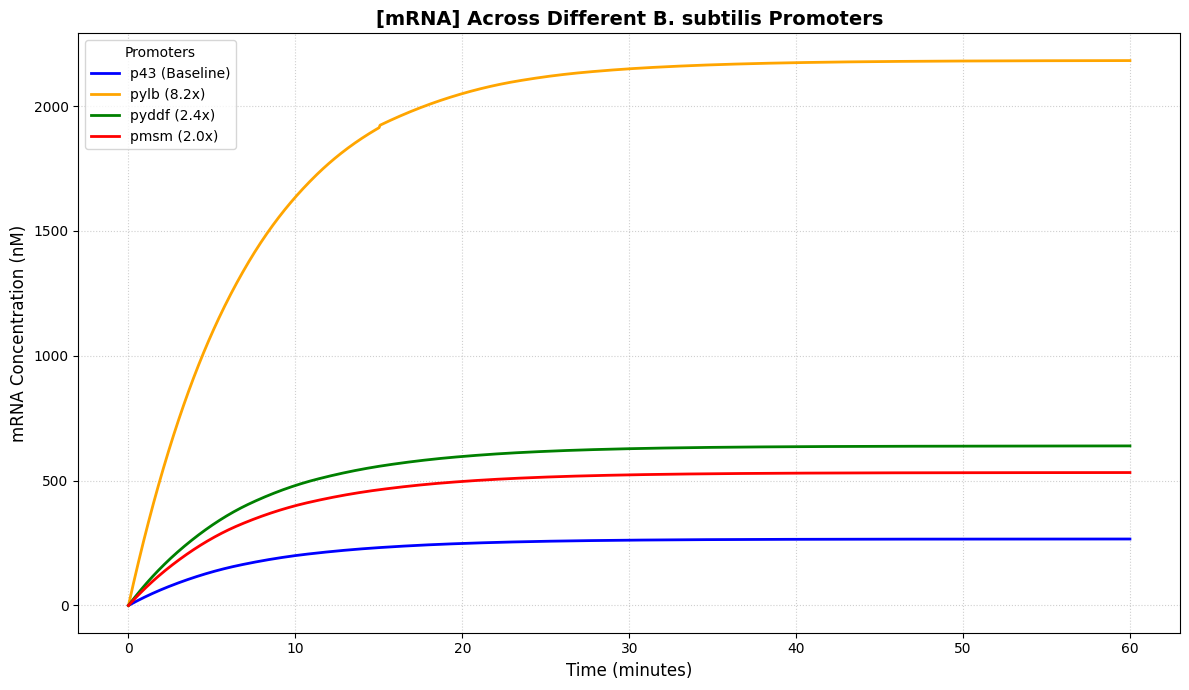

In [31]:
# =================================
# 1. Define Function
# =================================

def transcriptional_rate(m, t, p, kon_value):
    """
    Constitutive mRNA dynamics equation: 
    dm/dt = kon - d1 * m
    
    At steady-state (t >> elongation time):
    m_ss = kon / d1
    """
    dm_dt = (kon_value) - (p["d1"] * m)
    return dm_dt

# =================================
# 2. Simulation Setup
# =================================

t = np.linspace(0, 3600, 1000)  # Simulating for 1 hour (3600s)
initial_conditions = [0.0]

# Mapping keys for loop and plot labels
promoter_keys = ["kon_p43", "kon_pylb", "kon_pyddf", "kon_pmsm"]
labels = ["p43 (Baseline)", "pylb (8.2x)", "pyddf (2.4x)", "pmsm (2.0x)"]

# =================================
# 3. Run Simulation and Plot
# =================================

plt.figure(figsize=(12, 7))

# Dictionary to store maximum values for each promoter
m_max_values = {}

for key, name in zip(promoter_keys, labels):
    kon = params[key]
    # Solve ODE using the specific kon for this promoter
    sol = odeint(transcriptional_rate, initial_conditions, t, args=(params, kon))
    
    # Convert M to nM for biological relevance (1 M = 1e9 nM)
    sol_nM = sol * 1e9
    
    # Find maximum concentration
    max_conc = np.max(sol_nM)
    m_max_values[name] = max_conc
    
    # Convert seconds to minutes for plotting
    t_minutes = t / 60.0
    
    plt.plot(t_minutes, sol_nM, label=f'{name}', linewidth=2, 
             color={'p43 (Baseline)': 'blue', 
                    'pylb (8.2x)': 'orange', 
                    'pyddf (2.4x)': 'green', 
                    'pmsm (2.0x)': 'red'}[name])

# Visualization Styling
plt.title('[mRNA] Across Different B. subtilis Promoters', fontsize=14, fontweight='bold')
plt.xlabel('Time (minutes)', fontsize=12)
plt.ylabel('mRNA Concentration (nM)', fontsize=12)
plt.legend(title="Promoters")
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.savefig('output/01_mrna_concentrations.svg')

# Output Results
print("\nSIMULATION RESULTS (1 HOUR)")
print("="*50)
print(f"{'Promoter':<20} | {'Max [mRNA] (nM)':<15} | {'Molecules/cell':<15}")
print("-" * 60)
for name, val in m_max_values.items():
    molecules = val / 1e9 / UNIT_CONV
    print(f"{name:<20} | {val:>12.2f} | {molecules:>12.1f}")

## **4. Protein concentration prediction**

The protein concentration over time is described by the coupled ordinary differential equation [^1]:

$$\frac{dp}{dt} = \underbrace{k_{\text{trans}} \cdot m}_{\text{Translation Rate } (T)} \;-\; \underbrace{d_2 \cdot p}_{\text{Protein Degradation Rate } (D_p)}$$

where:

- $p$: Protein concentration (M)  
- $m$: mRNA concentration (M)  
- $k_{\text{trans}}$: Translation rate constant (s⁻¹)  
- $d_2$: Protein degradation rate (s⁻¹)  

The translation rate is proportional to the available mRNA concentration, reflecting that more mRNA templates lead to increased protein synthesis. Protein degradation follows first-order kinetics, where the decay rate is directly proportional to the current protein concentration.

---

### **Translation Rate Constant Determination**

The translation rate constant $k_{\text{trans}}$ represents the rate at which ribosomes complete protein synthesis per mRNA molecule. This parameter was determined using biological translation kinetics data from BioNumbers [^5]:

**Translation initiation rate:** Bacterial ribosomes initiate translation at approximately 5 events per minute per mRNA under typical growth conditions. This gives:

$$k_{\text{trans}} = \frac{5 \text{ initiations/min}}{60 \text{ s/min}} = 0.083 \text{ s}^{-1}$$

This means each mRNA molecule produces approximately **5 protein molecules per minute** at steady-state.

**Translation elongation dynamics:** With a ribosome elongation rate of 100 bp/s (≈33.3 amino acids/s) [^6], translating the full SpoVF protein (479 amino acids) requires approximately 14.4 seconds. Given the 12-second inter-initiation interval (1/k_trans), approximately **1.2 ribosomes** are actively translating each mRNA simultaneously at steady-state.

---

### **Ribosome Binding Site (RBS) Considerations**

The RBS sequence upstream of the SpoVF gene determines how efficiently ribosomes recognize and bind to the mRNA. In this project, the RBS was designed using the Salis Lab RBS Calculator [^2,3], which predicted a strength of 7,500 arbitrary units (AU) for the optimized sequence. 

A strong RBS (7,500 AU) ensures that nearly all mRNA molecules are recognized and translated by ribosomes, whereas a weak RBS may result in many mRNAs being ignored. However, once a ribosome is bound and actively translating, the elongation rate remains relatively constant at the biological baseline (~5 proteins/min/mRNA).

Therefore, we use the **biological baseline translation rate** (k_trans = 0.083 s⁻¹) in our model, assuming the strong RBS ensures efficient translation of all available mRNA.

---

#### **mRNA–Protein Coupled System**

The complete system for constitutive expression is described by two coupled ODEs:

**Equation (1) - mRNA dynamics:**
$$\frac{dm}{dt} = \underbrace{k_{\text{on}} \cdot c}_{\text{Transcription Rate}} \;-\; \underbrace{d_1 \cdot m}_{\text{mRNA Degradation}}$$

where $k_{\text{on}}$ represents the molar transcription rate (calculated in Section 2) and $c$ is the gene copy number.

**Equation (2) - Protein dynamics:**
$$\frac{dp}{dt} = \underbrace{k_{\text{trans}} \cdot m}_{\text{Translation Rate}} \;-\; \underbrace{d_2 \cdot p}_{\text{Protein Degradation}}$$

These equations are solved simultaneously to capture the temporal dynamics of both mRNA and protein accumulation, accounting for the different timescales of mRNA (t₁/₂ ≈ 5 min) and protein (t₁/₂ ≈ 20 hours) turnover.

We evaluate protein concentration over time using the transcription rates determined for each promoter in Section 2:

| Promoter | Transcription Rate ($k_{\text{on}}$) | Steady-State mRNA | Unit |
| :--- | :--- | :--- | :--- |
| **p43** | $1.54 \times 10^{-10}$ | 66.6 nM | M s⁻¹ |
| **pylb** | $1.26 \times 10^{-9}$ | 545.8 nM | M s⁻¹ |
| **pyddf** | $3.69 \times 10^{-10}$ | 159.8 nM | M s⁻¹ |
| **pmsm** | $3.08 \times 10^{-10}$ | 133.1 nM | M s⁻¹ |

---

### **Model Parameters and Calculated Values**

| Variables | Description | Value | Unit | Reference |
| :--- | :--- | :--- | :--- | :--- |
| **$k_{\text{trans}}$** | Translation rate constant | 0.083 | s⁻¹ | [^5] |
| **$d_2$** | Protein degradation rate | $9.63 \times 10^{-6}$ | s⁻¹ | [^4] |
| **$r_{\text{elong}}$** | Ribosome elongation rate | 33.3 | aa s⁻¹ | [^6] |
| **$t_{\text{translation}}$** | Time to translate SpoVF | 14.4 | s | Calculated |
| **$n_{\text{ribosomes}}$** | Average ribosomes per mRNA | 1.2 | dimensionless | Calculated |
| **SpoVF length** | Target protein amino acid length | 479 | aa | NCBI |
| **RBS strength** | Designed RBS strength | 7,500 | AU | [^2] |
| **$m$** | mRNA concentration | Variable | M | From Section 3 |
| **$p$** | Protein concentration | Variable | M | Predicted |

where $d_2$ was calculated from the average half-life of bacterial proteins (~20 hours) [^4]. For first-order degradation, the relationship between half-life ($t_{1/2}$) and rate constant is:

$$t_{1/2} = \frac{\ln 2}{d_2} \quad \Rightarrow \quad d_2 = \frac{\ln 2}{t_{1/2}} = \frac{0.693}{72000 \text{ s}} \approx 9.63 \times 10^{-6} \text{ s}^{-1}$$

The simulation was performed over 24 hours to capture the accumulation of protein. Given the long protein half-life (20 hours), the system reaches approximately **56% of steady-state** at 24 hours. The full steady-state concentration is:

$$p^* = \frac{k_{\text{trans}} \cdot m^*}{d_2}$$

For the p43 promoter with steady-state mRNA of 66.6 nM:

$$p^*_{\text{p43}} = \frac{0.083 \text{ s}^{-1} \times 6.66 \times 10^{-8} \text{ M}}{9.63 \times 10^{-6} \text{ s}^{-1}} \approx 5.76 \times 10^{-4} \text{ M} = 576 \text{ µM}$$

This corresponds to approximately **312,000 protein molecules per cell**, representing high but realistic expression for metabolic engineering applications.

---

[^1]: iGEM FCB-UANL 2021: https://2021.igem.org/Team:FCB-UANL

[^2]: Salis et al. 2009: https://www.nature.com/articles/nbt.1568

[^3]: Salis Lab RBS Calculator: https://salislab.net/software/design_rbs_calculator

[^4]: BioNumbers. Typical protein half-life: https://bionumbers.hms.harvard.edu/bionumber.aspx?id=111930&ver=2

[^5]: BioNumbers. Average translation initiation rate: https://bionumbers.hms.harvard.edu/bionumber.aspx?id=100059&ver=1

[^6]: BioNumbers. Ribosome elongation rate: https://bionumbers.hms.harvard.edu/bionumber.aspx?id=100233&ver=4

### **4.1 PARAMETERS**

In [32]:
# =================================
# 1. Set Initial Parameters
# =================================

params["d2"] = 0.00000963   # s-1 (Protein degradation)
# Previous parameters to predict translation rate (iGEM FCB-UANL 2021)
#params["gfppps"] = 0.4      # aa-1s-1 (GFP translation rate)
#params["gfpl"] = 238.0      # aa (GFP length)
#params["gfpf"] = 69         # Arbitrary Units (AU)
params["af"] = 7500.0       # AU (RBS force)
params["aa"] = 497.0        # aa (Protein length - SpoVF)

# =================================
# 2. Biological Translation Rates
# =================================

# Biological translation parameters
TL_INITIATION_RATE = 5.0 / 60.0  # 5 initiations/min/mRNA = 0.083 s^-1
RIBOSOME_ELONGATION_RATE = 100.0 / 3.0  # 100 bp/s = 33.3 aa/s

# Calculate translation time for SpoVF
translation_time = SPOVF_AA_LENGTH / RIBOSOME_ELONGATION_RATE  # ~14.4 seconds

# Protein degradation and translation rate
params["d2"] = 9.63e-06  # s^-1 (Protein degradation, t_1/2 = 20 hours)
params["k_trans"] = TL_INITIATION_RATE  # 0.083 s^-1 (biological baseline)

# Store reference parameters
params["tl_initiation"] = TL_INITIATION_RATE
params["ribosome_elong"] = RIBOSOME_ELONGATION_RATE
params["translation_time"] = translation_time

# =================================
# 3. Print parameters (removed from function to avoid multiple printings)
# =================================

print("ANALYSIS")
print("=" * 50)

print("\nTRANSLATION KINETICS:")
print(f"\t- Ribosome elongation rate: {RIBOSOME_ELONGATION_RATE:.1f} aa/s")
print(f"\t- Translation time (SpoVF, {SPOVF_AA_LENGTH} aa): {translation_time:.1f} seconds")
print(f"\t- Translation initiation rate: {TL_INITIATION_RATE*60:.1f} initiations/min/mRNA")
print(f"\t- k_trans: {params['k_trans']:.4f} s⁻¹ ({params['k_trans']*60:.1f} proteins/min/mRNA)")
print(f"\t- Protein degradation d2: {params['d2']:.2e} s⁻¹ (t_1/2 = {np.log(2)/params['d2']/3600:.1f} hours)")

# C. Calculate steady-state protein for validation
m_ss_p43 = params["kon_p43"] / params["d1"]
p_ss_p43 = (params["k_trans"] * m_ss_p43) / params["d2"]

print("\nSTEADY-STATE protein:")
print(f"\t- Steady-state: {p_ss_p43*1e6:.1f} µM ({p_ss_p43/UNIT_CONV:.0f} molecules/cell)")
print(f"\t- At 24h (~56% SS): {p_ss_p43*1e6*0.563:.1f} µM")
print(f"\t- Time to steady-state: {5*np.log(2)/params['d2']/3600:.1f} hours")

ANALYSIS

TRANSLATION KINETICS:
	- Ribosome elongation rate: 33.3 aa/s
	- Translation time (SpoVF, 479 aa): 14.4 seconds
	- Translation initiation rate: 5.0 initiations/min/mRNA
	- k_trans: 0.0833 s⁻¹ (5.0 proteins/min/mRNA)
	- Protein degradation d2: 9.63e-06 s⁻¹ (t_1/2 = 20.0 hours)

STEADY-STATE protein:
	- Steady-state: 2304.0 µM (1248703 molecules/cell)
	- At 24h (~56% SS): 1297.1 µM
	- Time to steady-state: 100.0 hours


### **4.2 SIMULATION**


SIMULATION RESULTS (24 HOURS)

Promoter             | [Protein] (µM)    | Molecules/cell    
----------------------------------------------------------------------
p43 (Baseline)       |           1297.18 |          703046
pylb (8.2x)          |          10636.77 |         5764917
pyddf (2.4x)         |           3113.23 |         1687307
pmsm (2.0x)          |           2594.35 |         1406086


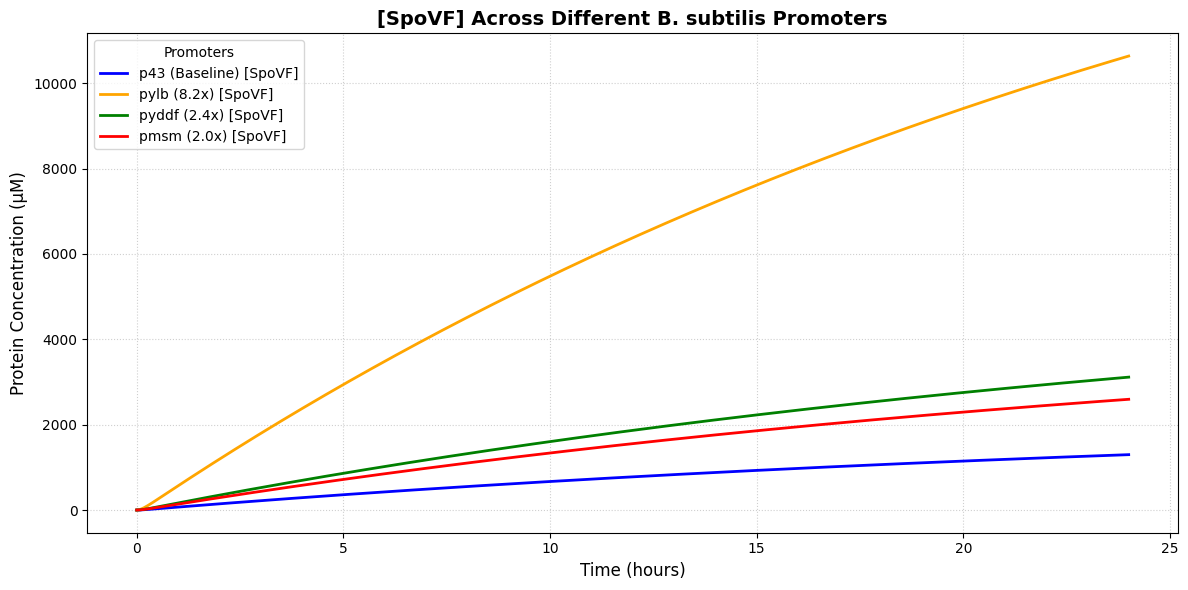

In [33]:
# =================================
# 3. Define Function
# =================================

def translational_rate(y, t, p, kon_value):
    """
    Coupled mRNA-Protein dynamics
    y[0] = mRNA concentration (M)
    y[1] = Protein concentration (M)
    """
    m, P = y

    # A. Transcription: dm/dt = kon - d1*m
    dm_dt = (kon_value) - (p["d1"] * m)
    
    # B. Translation: dP/dt = k_trans*m - d2*P
    dP_dt = (p["k_trans"] * m) - (p["d2"] * P)

    return [dm_dt, dP_dt]

# =================================
# 4. Simulation Setup
# =================================

t = np.linspace(0, 86400, 2000)  # Simulating for 24 hours (86400s)
initial_conditions = [0.0, 0.0]  # [Initial mRNA, Initial Protein]

# Mapping keys for loop and plot labels
promoter_keys = ["kon_p43", "kon_pylb", "kon_pyddf", "kon_pmsm"]
labels = ["p43 (Baseline)", "pylb (8.2x)", "pyddf (2.4x)", "pmsm (2.0x)"]

# =================================
# 5. Run Simulation and Plot
# =================================

plt.figure(figsize=(12, 6))

# Dictionary to store maximum values for each promoter
p_max_values = {}

for key, name in zip(promoter_keys, labels):
    kon = params[key]
    sol = odeint(translational_rate, initial_conditions, t, args=(params, kon))
    
    # Convert M to µM for biological relevance (NOT mM!)
    # 1 M = 1e6 µM (correct units for protein concentration)
    Protein_uM = sol[:, 1] * 1e6

    # Find maximum concentration
    max_conc = np.max(Protein_uM)
    p_max_values[name] = max_conc
    
    # Convert seconds to hours for plotting
    t_hours = t / 3600.0

    plt.plot(t_hours, Protein_uM, label=f'{name} [SpoVF]', linewidth=2,
             color={'p43 (Baseline)': 'blue',
                    'pylb (8.2x)': 'orange',
                    'pyddf (2.4x)': 'green',
                    'pmsm (2.0x)': 'red'}[name])

# Visualization Styling
plt.title('[SpoVF] Across Different B. subtilis Promoters', fontsize=14, fontweight='bold')
plt.ylabel('Protein Concentration (µM)', fontsize=12)  # Corrected units!
plt.xlabel('Time (hours)', fontsize=12)
plt.legend(title="Promoters")
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.savefig('output/02_protein_concentrations.svg')

# Output Results
print("\nSIMULATION RESULTS (24 HOURS)")
print("="*50)
print(f"\n{'Promoter':<20} | {'[Protein] (µM)':<17} | {'Molecules/cell':<18}")
print("-" * 70)
for name, val in p_max_values.items():
    molecules = val * 1e-6 / UNIT_CONV
    print(f"{name:<20} | {val:>17.2f} | {molecules:>15.0f}")

## **5. Catalytic velocity prediction**

The catalytic velocity of the enzyme SpoVF is described by Michaelis–Menten kinetics:

$$v = \frac{V_{\text{max}} \cdot [S]}{K_m + [S]}$$

where:

- $v$: reaction velocity (mM s⁻¹)
- $V_{\text{max}}$: maximum reaction velocity (mM s⁻¹)  
- $[S]$: substrate concentration (mM)  
- $K_m$: Michaelis constant (mM)  

Here, $V_{\text{max}}$ is assumed to be proportional to the enzyme concentration $[E]$:

$$V_{\text{max}} = k_{\text{cat}} \cdot [E]$$

where $k_{\text{cat}}$ is the turnover number (s⁻¹). The enzyme concentration $[E]$ is taken as the protein concentration of SpoVF predicted by the coupled ODE model.  

Two different substrate conditions, representing different cellular metabolic states, are compared:  

1. **Glucose (lower HTPA)** – substrate concentration equivalent to 5 mmol gDW⁻¹ h⁻¹, converted to mM s⁻¹.
2. **Glutamate (higher HTPA)** – substrate concentration equivalent to 6.7 mmol gDW⁻¹ h⁻¹, converted to mM s⁻¹.  

These values were retrieved using a Genomic-Scale Metabolic Model in B. subtilis in another study of our project.

For each promoter (p43, pylb, pyfdf, pmsm), the time‑course of protein concentration is first simulated using the coupled transcription–translation ODEs described above. This protein profile is then used together with the substrate concentration to compute the instantaneous catalytic velocity $v(t)$ via the Michaelis–Menten equation.  

This results on velocity profiles to illustrate how promoter strength and substrate availability together determine the enzyme's catalytic activity over time.

---

### **Model Parameters and Calculated Values**

| Variables | Description | Value | Unit | Reference |
| :--- | :--- | :--- | :--- | :--- |
| $ K_m $ (SpoVF) | Michaelis constant for SpoVF | 0.776 | mM | [^1] |
| $ k_{\text{cat}} $ (SpoVF) | Turnover number | 0.301 | s⁻¹ | [^1] |
| $ [S]_{\text{Glucose}} $ | Lower HTPA substrate concentration | ~1.39 × 10⁻³ | mM | Derived from 5 mmol·gDW⁻¹·h⁻¹ |
| $ [S]_{\text{Glutamate}} $ | Higher HTPA substrate concentration | ~1.86 × 10⁻³ | mM | Derived from 6.7 mmol·gDW⁻¹·h⁻¹ |
| $ [E]_{\text{SpoVF}} $ | SpoVF concentration dependent on promoter |  | mM |  |

$ [E]_{\text{SpoVF}} $ is calculated from the coupled transcription–translation ODEs described above.

The catalytic turnover number ($k_{\text{cat}}$) and Michaelis constant ($K_m$) for SpoVF were obtained from experimental characterization of the recombinant enzyme reported by McClintock et al. (2025) [^1]. In their study, purified SpoVF was assayed *in vitro* using dipicolinic acid (DPA) as substrate, and kinetic parameters were determined by fitting initial velocity data to the Michaelis–Menten equation. The reported $K_m$ is 0.776 mM. Additionally, the $k_{\text{cat}}$ value was derived from the specific enzymatic activity reported by McClintock et al. (2018), which measured 56.19 µg DPA (min × mg protein)⁻¹ using cell lysate containing SpoVF from *B. subtilis*.

We first convert the specific activity to molar units:

$$\text{Specific activity} = \frac{56.19 \text{ µg DPA}}{\text{min} \cdot \text{mg protein}} = \frac{0.05619 \text{ mg DPA}}{\text{min} \cdot \text{mg protein}}$$

$$= \frac{0.05619 \text{ mg}}{167.03 \text{ mg/mmol}} = 3.36 \times 10^{-4} \text{ mmol DPA/(min} \cdot \text{mg protein)}$$

$$= 0.336 \text{ µmol DPA/(min} \cdot \text{mg protein)}$$

Then convert mg protein to moles of enzyme:
   
Using the molecular weight of SpoVF complex = 53,741.32 Da (Retrieved from Expasy Compute pI/Mw Tool):
   
$$1 \text{ mg protein} = \frac{1 \text{ mg}}{53,741.32 \text{ mg/mol}} = 1.86 \times 10^{-5} \text{ mol enzyme}$$

$$= 18.6 \text{ nmol enzyme}$$

Finally, we calculate $k_{\text{cat}}$:

$$k_{\text{cat}} = \frac{0.336 \text{ µmol DPA/min}}{18.6 \text{ nmol enzyme}} = \frac{336 \text{ nmol DPA/min}}{18.6 \text{ nmol enzyme}}$$

$$= 18.06 \text{ min}^{-1} = \frac{18.06}{60} \text{ s}^{-1} = 0.301 \text{ s}^{-1}$$

**Important note:** This value represents a **lower bound estimate** because the original measurement was performed on crude cell lysate rather than purified enzyme. The total protein concentration includes all cellular proteins, not only SpoVF. The true $k_{\text{cat}}$ of purified SpoVF might differ, depending on the fraction of SpoVF in the lysate. However, for modeling purposes, this conservative estimate provides a baseline for enzyme kinetics under cellular conditions.

---

[^1]: McClintock et al. 2025: https://pmc.ncbi.nlm.nih.gov/articles/PMC12317343/

### **5.1 PARAMETERS**

In [34]:
# =================================
# 1. Set Initial Parameters
# =================================

params["KMspovf"] = 0.776                                   # mM; Michaelis constant for SpoVF
params["kcatspovf"] = 0.301                                 # s^-1; turnover number

# Convert flux to production rate (mM/s)
v_prod_glucose = 5.0 / 3600      # mmol/gDW/h
v_prod_glutamate = 6.7 / 3600    # mmol/gDW/h

# Store results
params["HTPA_glutamate"] = v_prod_glutamate     # mM (higher HTPA availability with glutamate)
params["HTPA_glucose"] = v_prod_glucose         # mM (lower HTPA availability with glucose)

# =================================
# 2. Print parameters 
# =================================

print("ANALYSIS")
print("=" * 50)

print("\nENZYME KINETIC PARAMETERS:")
print(f"\t- Km (SpoVF): {params['KMspovf']:.3f} mM")
print(f"\t- kcat (SpoVF): {params['kcatspovf']:.6f} s⁻¹")
print()

print("\nSUBSTRATE CONCENTRATIONS:")
print(f"\t- HTPA (glucose conditions): {params['HTPA_glucose']:.4f} mM")
print(f"\t- HTPA (glutamate conditions): {params['HTPA_glutamate']:.4f} mM")
print()

# Calculate fractional saturation for each condition
frac_sat_glucose = params["HTPA_glucose"] / (params["KMspovf"] + params["HTPA_glucose"])
frac_sat_glutamate = params["HTPA_glutamate"] / (params["KMspovf"] + params["HTPA_glutamate"])

print("\nENZYME SATURATION:")
print(f"\t- Fractional saturation (glucose): {frac_sat_glucose*100:.1f}%")
print(f"\t- Fractional saturation (glutamate): {frac_sat_glutamate*100:.1f}%")

ANALYSIS

ENZYME KINETIC PARAMETERS:
	- Km (SpoVF): 0.776 mM
	- kcat (SpoVF): 0.301000 s⁻¹


SUBSTRATE CONCENTRATIONS:
	- HTPA (glucose conditions): 0.0014 mM
	- HTPA (glutamate conditions): 0.0019 mM


ENZYME SATURATION:
	- Fractional saturation (glucose): 0.2%
	- Fractional saturation (glutamate): 0.2%


### **5.2 SIMULATION**

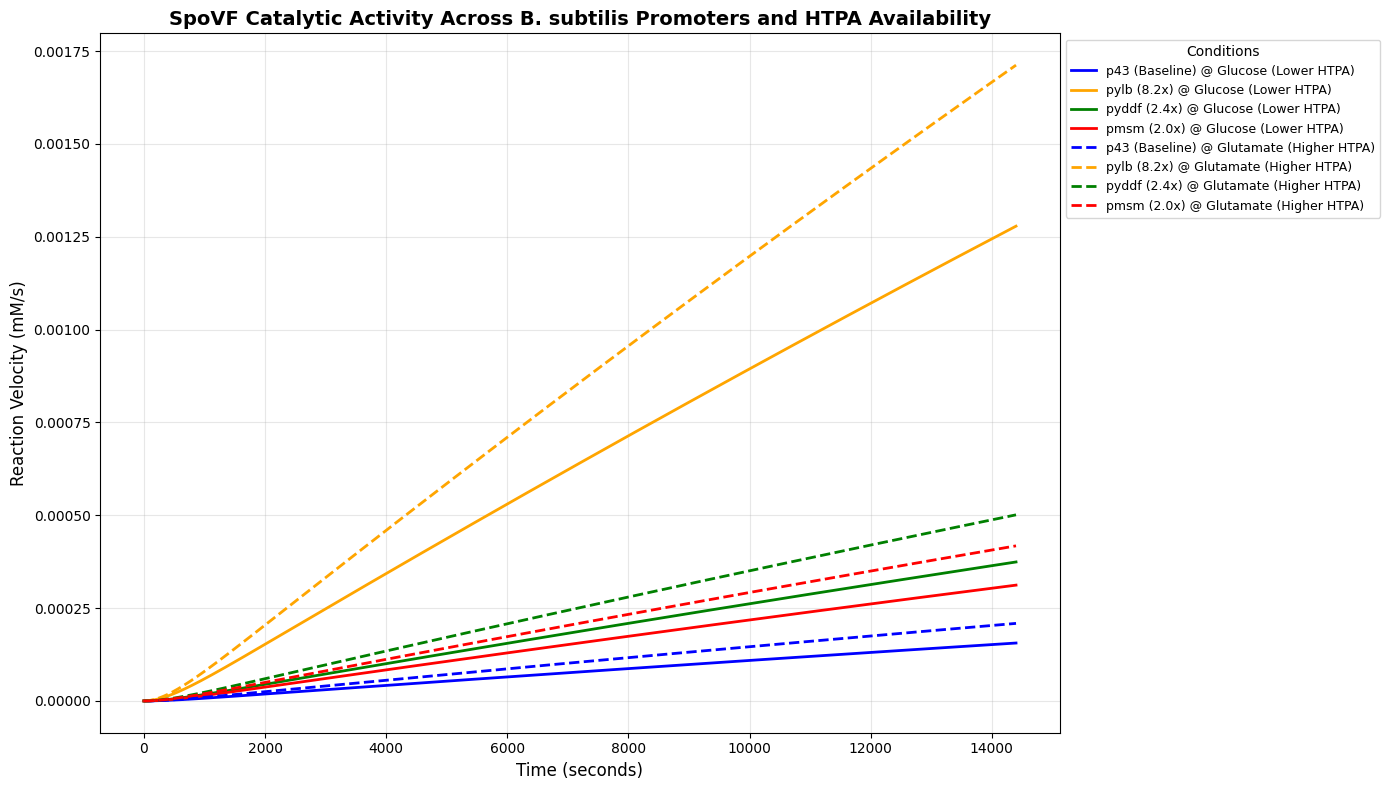


SIMULATION RESULTS (4 HOURS)
Condition                                     | Velocity (mM/s) | Velocity (µM/s)
-------------------------------------------------------------------------------------
p43 (Baseline) @ Glucose (Lower HTPA)         | 1.559322e-04 | 1.559322e-01
p43 (Baseline) @ Glutamate (Higher HTPA)      | 2.088223e-04 | 2.088223e-01
pmsm (2.0x) @ Glucose (Lower HTPA)            | 3.118561e-04 | 3.118561e-01
pmsm (2.0x) @ Glutamate (Higher HTPA)         | 4.176334e-04 | 4.176334e-01
pyddf (2.4x) @ Glucose (Lower HTPA)           | 3.742254e-04 | 3.742254e-01
pyddf (2.4x) @ Glutamate (Higher HTPA)        | 5.011576e-04 | 5.011576e-01
pylb (8.2x) @ Glucose (Lower HTPA)            | 1.278541e-03 | 1.278541e+00
pylb (8.2x) @ Glutamate (Higher HTPA)         | 1.712205e-03 | 1.712205e+00

=== BIOLOGICAL VALIDATION ===
Typical enzyme velocities in bacteria: 0.1-100 µM/s
Calculated velocities: 1.56e-01 - 1.71e+00 µM/s


In [35]:
# =================================
# 3. Define Function
# =================================

def calculate_catalytic_rate(protein_conc, substrate_conc, p):
    """
    Calculates reaction velocity using Michaelis-Menten kinetics:
    v = (kcat * [E] * [S]) / (Km + [S])
    """
    # Vmax = kcat * [Enzyme]
    vmax = p["kcatspovf"] * protein_conc
    
    # Michaelis-Menten equation
    v = (vmax * substrate_conc) / (p["KMspovf"] + substrate_conc)
    
    return v

# =================================
# 4. Simulation Setup
# =================================

t = np.linspace(0, 14400, 2000)  # 4 hours
initial_conditions = [0.0, 0.0]  # [mRNA, Protein]

# Substrate conditions
htpa_conditions = {
    "Glucose (Lower HTPA)": params["HTPA_glucose"],
    "Glutamate (Higher HTPA)": params["HTPA_glutamate"]
}

# Promoter keys
promoter_keys = ["kon_p43", "kon_pylb", "kon_pyddf", "kon_pmsm"]
labels = ["p43 (Baseline)", "pylb (8.2x)", "pyddf (2.4x)", "pmsm (2.0x)"]

# =================================
# 5. Run Simulation and Plot
# =================================

plt.figure(figsize=(14, 8))

# Store results for analysis
velocity_results = {}

for env_name, htpa_val in htpa_conditions.items():
    for key, name in zip(promoter_keys, labels):
        kon = params[key]
        
        # Solve ODE for Protein concentration
        sol = odeint(translational_rate, initial_conditions, t, args=(params, kon))
        
        # Extract protein concentration in mM (1 M = 1000 mM)
        protein_mM = sol[:, 1] * 1e3
        
        # Calculate velocity over time
        velocity = calculate_catalytic_rate(protein_mM, htpa_val, params)
        
        # Store final velocity
        key_name = f"{name} @ {env_name}"
        velocity_results[key_name] = velocity[-1]  # Final velocity
        
        # Style selection: Solid lines for Glucose, Dashed for Glutamate
        line_style = '-' if "Glucose" in env_name else '--'
        
        plt.plot(t, velocity, label=key_name, 
                 linestyle=line_style, linewidth=2,
                 color={'p43 (Baseline)': 'blue',
                        'pylb (8.2x)': 'orange',
                        'pyddf (2.4x)': 'green',
                        'pmsm (2.0x)': 'red'}[name])

# Visualization Styling
plt.ylabel('Reaction Velocity (mM/s)', fontsize=12)
plt.xlabel('Time (seconds)', fontsize=12)
plt.title('SpoVF Catalytic Activity Across B. subtilis Promoters and HTPA Availability', fontsize=14, fontweight='bold')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Conditions", fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('output/03_catalytic_velocity.svg')
plt.show()

# Output Results
print("\nSIMULATION RESULTS (4 HOURS)")
print("="*50)
print(f"{'Condition':<45} | {'Velocity (mM/s)':<15} | {'Velocity (µM/s)':<15}")
print("-" * 85)
for condition, vel in sorted(velocity_results.items()):
    print(f"{condition:<45} | {vel:.6e} | {vel*1000:.6e}")

print("\n=== BIOLOGICAL VALIDATION ===")
print(f"Typical enzyme velocities in bacteria: 0.1-100 µM/s")
print(f"Calculated velocities: {min(velocity_results.values())*1000:.2e} - {max(velocity_results.values())*1000:.2e} µM/s")

## **6. Product Accumulation Prediction (DPA Mass)**

To translate the catalytic activity into a practical bioprocess output, we calculate the total mass of dipicolinic acid (DPA) produced by integrating the reaction velocity over time and scaling the result to a bioreactor volume. We evaluate DPA production under:

1. **Scenario 1: Metabolic Flux-Based Production** – Substrate (HTPA) concentrations are derived from genomic-scale metabolic model predictions where production rates correspond to:
   - **Glucose (lower HTPA)** – substrate flux equivalent to 5 mmol gDW⁻¹ h⁻¹
   - **Glutamate (higher HTPA)** – substrate flux equivalent to 6.7 mmol gDW⁻¹ h⁻¹
   
   This scenario is simulated over **24 hours** and evaluated at two biomass concentrations (5 gDW L⁻¹ and 45 gDW L⁻¹).

We assume the bioreactor operates under steady-state nutrient supply (continuous chemostat or fed-batch system) where HTPA production rates are maintained.

---

The instantaneous reaction velocity $v(t)$ (in mM s⁻¹) is calculated using Michaelis–Menten kinetics and integrated over the simulation timescale using the **trapezoidal rule** to obtain the total millimoles of DPA produced per unit cell volume:

$$\text{total\_mM\_internal} = \int_0^{T} v(t) \, dt$$

This represents the cumulative amount of DPA (in millimoles per liter of cell volume) synthesized over time.

To scale from cellular volume to bioreactor volume, a volume fraction is applied based on the biomass concentration and cell density. Assuming approximately 0.9 fL (9×10⁻¹⁵ L) per *B. subtilis* cell and a cell density of 3×10¹¹ cells per gram of dry weight:

$$m_{\text{bioreactor}} \; [\text{mmol}] = m_{\text{internal}} \; [\text{mmol}] \times \left( C_{\text{biomass}} \; [\text{g L⁻¹}] \times \rho_{\text{cells}} \; [\text{cells g⁻¹}] \times V_{\text{cell}} \; [\text{L cell⁻¹}] \right)$$

Finally, the molecular weight of DPA is used to convert the total millimoles to grams per liter:

$$C_{\text{dpa, g L⁻¹}} = \frac{m_{\text{bioreactor, mmol}} \cdot M_{\text{dpa, g mol⁻¹}}}{1000 \; \text{mmol mol⁻¹}}$$

This yields the final **DPA concentration in g L⁻¹** at the end of each simulation period.

---

### **Assumptions**

#### 1. Degradation Rate and DPA Toxicity

No degradation rate for DPA was incorporated into the model. The bioreactor operates at standard physiological temperatures (20–37°C), where DPA exhibits minimal spontaneous degradation or enzymatic breakdown. Additionally, the relatively short production timescale modeled (24 hours) means that any degradation losses would be negligible compared to production rates. Therefore, the model treats DPA as a stable end product that accumulates linearly once synthesized. 

However, DPA toxicity can be a critical variable during bioprocess scale-up, not accounted on our model. At high concentrations, DPA may exert osmotic stress on cells, reduce growth rate, and inhibit SpoVF enzymatic activity through pH changes and osmotic imbalance.

#### 2. Fixed Precursor Availability and Metabolic Burden

The model assumes HTPA is available at the flux rate predicted by an initial genome-scale metabolic model, although the metabolic burden experimentally may reduce overall DPA yields.

#### 3. Uniform Conditions Under Bioreactor Scale-Up

The model assumes:

- All cells in the bioreactor experience identical nutrient availability, oxygen tension, and pH
- Cell density, growth rate, and gene expression are uniform throughout the vessel
- No mass transfer limitations on oxygen or nutrients
- Metabolic state is homogeneous

#### 4. Protein Aggregation and Proteolysis

At high expression levels, SpoVF is at risk of misfolding, aggregation into inclusion bodies, and proteolytic degradation by cellular quality-control systems (ClpX/ClpP, Lon proteases). The model assumes all synthesized SpoVF remains soluble and active, with protein degradation following simple first-order kinetics (half-life = 20 hours). 

---

### **Model Parameters and Calculated Values**

| Variables | Description | Value | Unit | Reference |
| :--- | :--- | :--- | :--- | :--- |
| **$C_{\text{biomass}}$** | Dry biomass concentration in the bioreactor | 5.0 or 45.0 | g L⁻¹ | Custom |
| **$\rho_{\text{cells}}$** | Cell density of *B. subtilis* | 1.0 × 10¹² | cells g⁻¹ | [^1] |
| **$V_{\text{cell}}$** | Cell volume of *B. subtilis* | 0.9×10⁻¹⁵ | L cell⁻¹ | [^2] |
| **$M_{\text{dpa}}$** | Molecular weight of dipicolinic acid | 167.12 | g mol⁻¹ | PubChem |
| **$t_{\text{sim, scenario 1}}$** | Simulation duration (metabolic flux-based) | 86,400 | s (24 h) | Custom |
| **$m_{\text{bioreactor}}$** | Total millimoles of DPA scaled to bioreactor volume | Variable | mmol | Calculated |
| **$C_{\text{dpa}}$** | Final DPA titer achieved at end of production period | Variable | g L⁻¹ | Calculated |

The cell density (cells per gram of dry weight) was derived from the physical density of bacteria obtained from BioNumbers. Given:

- **Physical cell density** (ρ_cell): 1.1 g cm⁻³ (BioNumbers)
- **Cell volume** (V_cell): 0.9 μm³ = 0.9×10⁻¹² cm³

The mass of a single *B. subtilis* cell is:

$$m_{\text{cell}} = \rho_{\text{cell}} \times V_{\text{cell}} = 1.1 \; \text{g cm⁻¹}^3 \times 0.9 \times 10^{-12} \; \text{cm}^3 = 0.99 \times 10^{-12} \; \text{g}$$

Therefore, the number of cells per gram of dry biomass is:

$$\rho_{\text{cells}} = \frac{1 \; \text{g}}{0.99 \times 10^{-12} \; \text{g cell⁻¹}} \approx 1.0 \times 10^{12} \; \text{cells gDW⁻¹}$$

This value represents the theoretical maximum cell density assuming all biomass consists of cellular material. Nonetheless, real cultures may contain extracellular polysaccharides, protein aggregates, and other non-cellular components, but this estimate provides a consistent basis grounded in experimental biophysical measurements from BioNumbers.

---

[^1]: BioNumbers. Average density: https://bionumbers.hms.harvard.edu/bionumber.aspx?id=102239&ver=4

[^2]: BioNumbers. Cell Volume: https://bionumbers.hms.harvard.edu/bionumber.aspx?id=114922&ver=0


### **6.1 Evaluate production under metabolic flux rates**

#### **6.1.1 PARAMETERS**

In [36]:
# =================================
# 1. Set Initial Parameters
# =================================

params["biomass_gl"] = 5.0          # gDW/L
params["MW_dpa"] = 167.12           # g/mol
params["cell_density"] = 1e12       # cells/gDW
T_PRODUCTION = 24 * 3600            # seconds

# Metabolic fluxes
flux_glucose = 5.0      # mmol/gDW/h
flux_glutamate = 6.7    # mmol/gDW/h

# Convert flux to production rate (mM/s)
v_prod_glucose = (flux_glucose * params["biomass_gl"]) / 3600
v_prod_glutamate = (flux_glutamate * params["biomass_gl"]) / 3600

# Store results
params["v_prod_glucose"] = v_prod_glucose
params["v_prod_glutamate"] = v_prod_glutamate

# =================================
# 2. Print parameters 
# =================================

print("ANALYSIS")
print("=" * 50)

print("\nPROCESS CONDITIONS:")
print(f"\t- Biomass: {params['biomass_gl']} gDW/L")
print(f"\t- Cell density: {params['cell_density']:.2e} cells/gDW")
print(f"\t- Total cells: {params['biomass_gl'] * params['cell_density']:.2e} cells/L")
print(f"\t- Production time: {T_PRODUCTION/3600:.0f} hours")
print(f"\t- DPA MW: {params['MW_dpa']} g/mol")
print("\nMETABOLIC FLUXES (HTPA):")
print(f"\tGlucose: {flux_glucose} mmol/gDW/h")
print(f"\tGlutamate: {flux_glutamate} mmol/gDW/h")
print("\nCONCENTRATIONS RATES (HTPA):")
print(f"\tGlucose: {round(params["v_prod_glucose"], 4)} mmol/s")
print(f"\tGlutamate: {round(params["v_prod_glutamate"], 4)} mmol/s")

ANALYSIS

PROCESS CONDITIONS:
	- Biomass: 5.0 gDW/L
	- Cell density: 1.00e+12 cells/gDW
	- Total cells: 5.00e+12 cells/L
	- Production time: 24 hours
	- DPA MW: 167.12 g/mol

METABOLIC FLUXES (HTPA):
	Glucose: 5.0 mmol/gDW/h
	Glutamate: 6.7 mmol/gDW/h

CONCENTRATIONS RATES (HTPA):
	Glucose: 0.0069 mmol/s
	Glutamate: 0.0093 mmol/s


#### **6.1.2 SIMULATION**

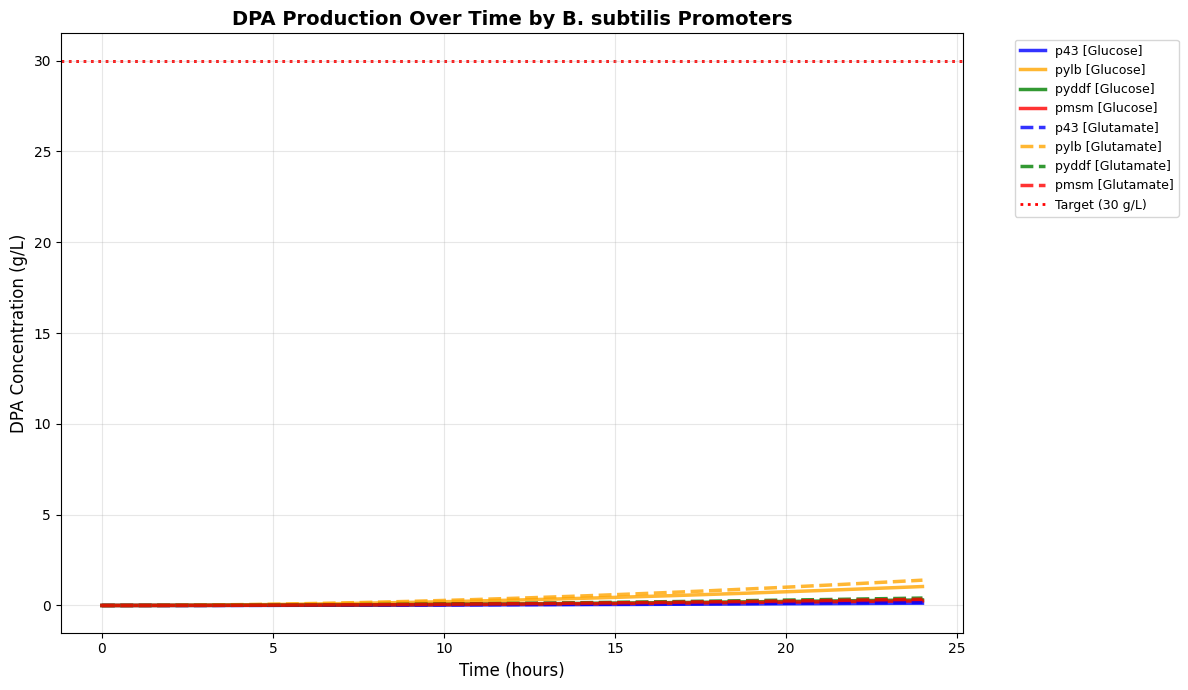

DPA PRODUCTION RESULTS (24h)
Promoter        | Glucose (g/L)   | Glutamate (g/L)   | Best (g/L)  
----------------------------------------------------------------------
p43             |          0.13 |            0.17 |       0.17
pylb            |          1.04 |            1.39 |       1.39
pyddf           |          0.31 |            0.41 |       0.41
pmsm            |          0.25 |            0.34 |       0.34

Target not reached:
	- Best: pylb with Glutamate
	- Production: 1.39 g/L
	- Shortfall: 28.61 g/L


In [37]:
# =================================
# 3. Simulation Setup
# =================================

t_seconds = np.linspace(0, T_PRODUCTION, 1000)
t_hours = t_seconds / 3600
initial_conditions = [0.0, 0.0]  # [mRNA, Protein]

# Promoter setup
promoter_keys = ["kon_p43", "kon_pylb", "kon_pyddf", "kon_pmsm"]
promoter_labels = ["p43", "pylb", "pyddf", "pmsm"]
colors_map = plt.colormaps.get_cmap('tab10')
promoter_colors = {label: colors_map(i) for i, label in enumerate(promoter_labels)}

# Storage for results
results = {}

# Conditions
conditions = {
    "Glucose": v_prod_glucose,
    "Glutamate": v_prod_glutamate
}

# =================================
# 5. Run Simulation and Plot
# =================================

# Visualization
plt.figure(figsize=(12, 7))

for condition_name, htpa_conc in conditions.items():    
    for key, label in zip(promoter_keys, promoter_labels):
        kon = params[key]
        
        # Solve protein dynamics
        sol = odeint(translational_rate, initial_conditions, t_seconds, args=(params, kon))
        protein_mM = sol[:, 1] * 1e3  # M to mM
        
        # Calculate velocity (mM/s per L_cell)
        velocity = (params["kcatspovf"] * protein_mM * htpa_conc) / (params["KMspovf"] + htpa_conc)

        # Integrate to get mmol per L_cell
        cumulative_mmol_per_Lcell = cumulative_trapezoid(velocity, t_seconds, initial=0)

        # SCALE TO BIOREACTOR: account for cell density
        cell_volume_L = 0.9e-15  # L/cell
        cells_per_L = params['cell_density'] * params['biomass_gl']  # cells/L_bioreactor
        cellular_volume_fraction = cell_volume_L * cells_per_L  # L_cells/L_bioreactor

        # Convert to bioreactor scale
        cumulative_mmol_bioreactor = cumulative_mmol_per_Lcell * cellular_volume_fraction

        # Convert mmol to g
        cumulative_dpa = (cumulative_mmol_bioreactor * params["MW_dpa"]) / 1000
    
        # Store final result
        final_dpa = cumulative_dpa[-1]
        results[f"{label}_{condition_name}"] = final_dpa
        
        # Plot
        linestyle = '-' if condition_name == "Glucose" else '--'
        plt.plot(t_hours, cumulative_dpa, linestyle=linestyle, linewidth=2.5,
                 color={'p43': 'blue',
                        'pylb': 'orange',
                        'pyddf': 'green',
                        'pmsm': 'red'}[label],
                 label=f'{label} [{condition_name}]', alpha=0.8)

# Target line
plt.axhline(y=30, color='red', linestyle=':', linewidth=2, 
            label='Target (30 g/L)', zorder=1)

plt.title('DPA Production Over Time by B. subtilis Promoters', fontsize=14, fontweight='bold')
plt.xlabel('Time (hours)', fontsize=12)
plt.ylabel('DPA Concentration (g/L)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('output/04_dpa_production_under_metabolic_flux.svg', dpi=150)
plt.show()

# Output Results
print("DPA PRODUCTION RESULTS (24h)")
print("="*50)
print(f"{'Promoter':<15} | {'Glucose (g/L)':<15} | {'Glutamate (g/L)':<17} | {'Best (g/L)':<12}")
print("-" * 70)

for label in promoter_labels:
    gluc = results[f"{label}_Glucose"]
    glut = results[f"{label}_Glutamate"]
    best = max(gluc, glut)
    print(f"{label:<15} | {gluc:>13.2f} | {glut:>15.2f} | {best:>10.2f}")

# Find best result
best_key = max(results, key=results.get)
best_value = results[best_key]
best_promoter = best_key.split('_')[0]
best_condition = best_key.split('_')[1]

if best_value >= 30:
    print("\nTARGET ACHIEVED:")
    print(f"\t- Best: {best_promoter} with {best_condition}")
    print(f"\t- Production: {best_value:.2f} g/L")
    print(f"\t- Achievement: {best_value/30*100:.1f}% of target")
else:
    print("\nTarget not reached:")
    print(f"\t- Best: {best_promoter} with {best_condition}")
    print(f"\t- Production: {best_value:.2f} g/L")
    print(f"\t- Shortfall: {30 - best_value:.2f} g/L")

### **6.2 Evaluate minimum biomass (g/L) under metabolic flux rates**

#### **6.2.1 PARAMETERS**

In [38]:
# =================================
# 1. Modify Initial Parameters
# =================================

# Define biomass concentrations to test
biomass_concentrations = [5.0, 15.0, 25.0]  # gDW/L

all_results = {}

for biomass_gl in biomass_concentrations:
    # Calculate production rates for this biomass
    v_prod_glucose = (flux_glucose * biomass_gl) / 3600
    v_prod_glutamate = (flux_glutamate * biomass_gl) / 3600
    
    all_results[biomass_gl] = {
        "v_prod_glucose": v_prod_glucose,
        "v_prod_glutamate": v_prod_glutamate,
        "total_cells": biomass_gl * params['cell_density']
    }

print("ANALYSIS (FOUR SIMULATIONS)")
print("=" * 50)

print("\nPROCESS CONDITIONS:")
print(f"\t- Biomass: {', '.join([f'{b} gDW/L' for b in biomass_concentrations])}")
print(f"\t- Cell density: {params['cell_density']:.2e} cells/gDW")
print("\tTotal cells per condition:")
for biomass_gl in biomass_concentrations:
    total_cells = biomass_gl * params['cell_density']
    print(f"\t\t{biomass_gl} g/L: {total_cells:.2e} cells/L")
print(f"\t- Production time: {T_PRODUCTION/3600:.0f} hours")
print(f"\t- DPA MW: {params['MW_dpa']} g/mol")
print("\nMETABOLIC FLUXES (HTPA):")
print(f"\tGlucose: {flux_glucose} mmol/gDW/h")
print(f"\tGlutamate: {flux_glutamate} mmol/gDW/h")
print("\nCONCENTRATION RATES (HTPA) BY BIOMASS:")
for biomass_gl in biomass_concentrations:
    print(f"\t{biomass_gl} g/L:")
    print(f"\t\tGlucose: {all_results[biomass_gl]['v_prod_glucose']:.4f} mmol/s")
    print(f"\t\tGlutamate: {all_results[biomass_gl]['v_prod_glutamate']:.4f} mmol/s")

ANALYSIS (FOUR SIMULATIONS)

PROCESS CONDITIONS:
	- Biomass: 5.0 gDW/L, 15.0 gDW/L, 25.0 gDW/L
	- Cell density: 1.00e+12 cells/gDW
	Total cells per condition:
		5.0 g/L: 5.00e+12 cells/L
		15.0 g/L: 1.50e+13 cells/L
		25.0 g/L: 2.50e+13 cells/L
	- Production time: 24 hours
	- DPA MW: 167.12 g/mol

METABOLIC FLUXES (HTPA):
	Glucose: 5.0 mmol/gDW/h
	Glutamate: 6.7 mmol/gDW/h

CONCENTRATION RATES (HTPA) BY BIOMASS:
	5.0 g/L:
		Glucose: 0.0069 mmol/s
		Glutamate: 0.0093 mmol/s
	15.0 g/L:
		Glucose: 0.0208 mmol/s
		Glutamate: 0.0279 mmol/s
	25.0 g/L:
		Glucose: 0.0347 mmol/s
		Glutamate: 0.0465 mmol/s


#### **6.2.2 EXECUTION**

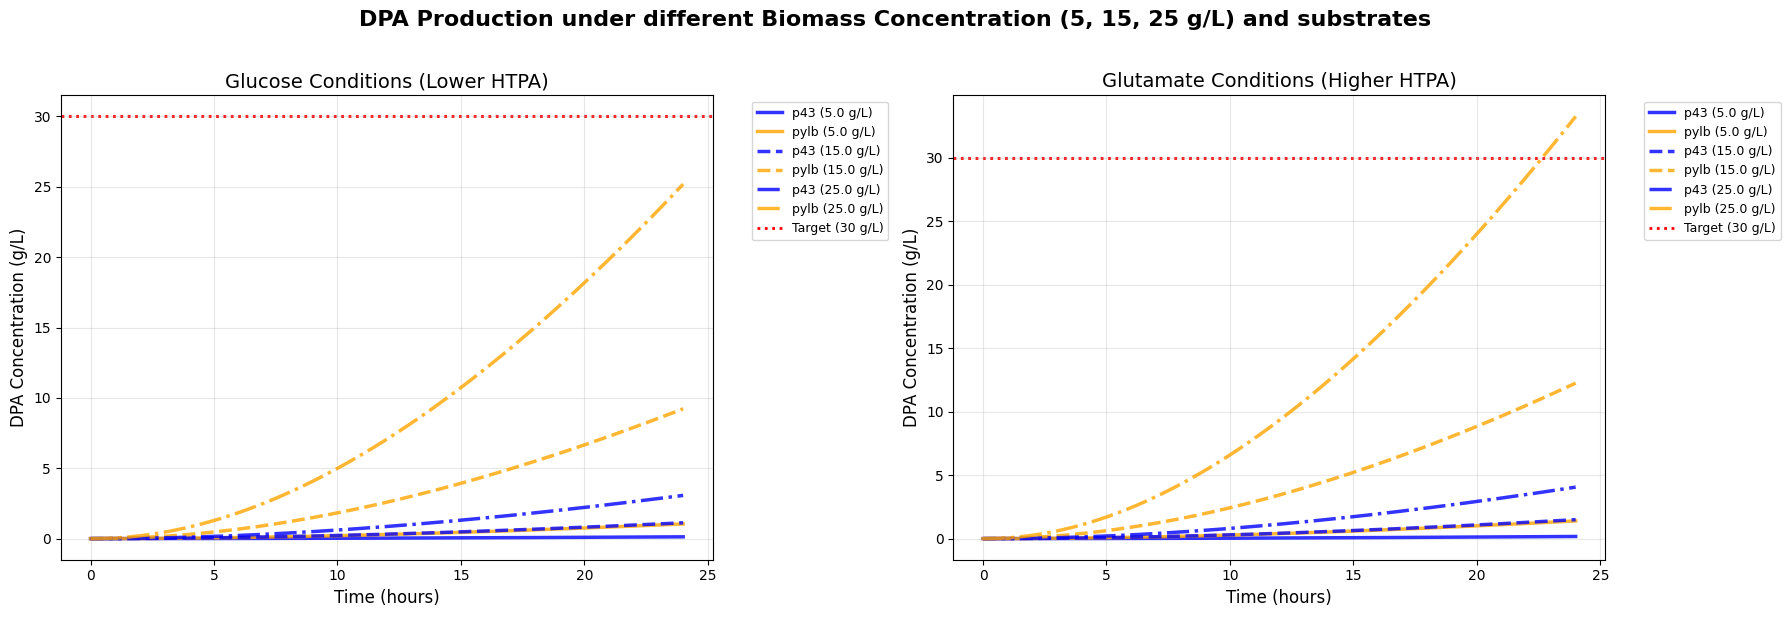


DPA PRODUCTION RESULTS (24h) - Biomass: 5.0 gDW/L

Promoter        | Glucose (g/L)   | Glutamate (g/L)   | Best (g/L)  
--------------------------------------------------------------------------------
p43             |          0.13 |            0.17 |       0.17
pylb            |          1.04 |            1.39 |       1.39

Target not reached:
	- Best: pylb with Glutamate
	- Production: 1.39 g/L
	- Shortfall: 28.61 g/L

DPA PRODUCTION RESULTS (24h) - Biomass: 15.0 gDW/L

Promoter        | Glucose (g/L)   | Glutamate (g/L)   | Best (g/L)  
--------------------------------------------------------------------------------
p43             |          1.13 |            1.49 |       1.49
pylb            |          9.23 |           12.25 |      12.25

Target not reached:
	- Best: pylb with Glutamate
	- Production: 12.25 g/L
	- Shortfall: 17.75 g/L

DPA PRODUCTION RESULTS (24h) - Biomass: 25.0 gDW/L

Promoter        | Glucose (g/L)   | Glutamate (g/L)   | Best (g/L)  
------------------------

In [39]:
# =================================
# 2. Simulation Setup
# =================================
t_seconds = np.linspace(0, T_PRODUCTION, 1000)
t_hours = t_seconds / 3600
initial_conditions = [0.0, 0.0]  # [mRNA, Protein]

# Promoter setup
promoter_keys = ["kon_p43", "kon_pylb"]  # Just p43 and pylb for clarity
promoter_labels = ["p43", "pylb"]
colors_map = plt.colormaps.get_cmap('tab10')
promoter_colors = {label: colors_map(i) for i, label in enumerate(promoter_labels)}

# Line styles for each biomass concentration
biomass_styles = {5.0: '-', 15.0: '--', 25.0: '-.'}

# Storage for all results
simulation_results = {}

# =================================
# 3. Create Plot
# =================================

# Create a single figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('DPA Production under different Biomass Concentration (5, 15, 25 g/L) and substrates', 
             fontsize=16, fontweight='bold', y=1.02)

# Left plot: Glucose conditions
ax1 = axes[0]
# Right plot: Glutamate conditions
ax2 = axes[1]

# Loop through each biomass concentration
for biomass_idx, (biomass_gl, biomass_params) in enumerate(all_results.items()):
    # Update params with current biomass
    params["biomass_gl"] = biomass_gl
    params["v_prod_glucose"] = biomass_params["v_prod_glucose"]
    params["v_prod_glutamate"] = biomass_params["v_prod_glutamate"]
    
    # Get line style for this biomass
    line_style = biomass_styles[biomass_gl]
    biomass_label = f"{biomass_gl} g/L"
    
    # Storage for this biomass concentration simulation results
    results = {}
    
    # Conditions
    conditions = {
        "Glucose": params["v_prod_glucose"],
        "Glutamate": params["v_prod_glutamate"]
    }
    
    # Process each condition
    for condition_name, htpa_conc in conditions.items():
        # Select the appropriate axis
        ax = ax1 if condition_name == "Glucose" else ax2
        
        for key, label in zip(promoter_keys, promoter_labels):
            kon = params[key]
            
            # Solve protein dynamics
            sol = odeint(translational_rate, initial_conditions, t_seconds, 
                         args=(params, kon))
            protein_mM = sol[:, 1] * 1e3  # M to mM
            
            # Calculate velocity (mM/s per L_cell)
            velocity = (params["kcatspovf"] * protein_mM * htpa_conc) / \
                    (params["KMspovf"] + htpa_conc)
            
            # Integrate to get mmol per L_cell
            cumulative_mmol_per_Lcell = cumulative_trapezoid(velocity, t_seconds, initial=0)
            
            # SCALE TO BIOREACTOR: account for cell density
            cell_volume_L = 0.9e-15  # L/cell
            cells_per_L = params['cell_density'] * params['biomass_gl']  # cells/L_bioreactor
            cellular_volume_fraction = cell_volume_L * cells_per_L  # L_cells/L_bioreactor
            
            # Convert to bioreactor scale
            cumulative_mmol_bioreactor = cumulative_mmol_per_Lcell * cellular_volume_fraction
            
            # Convert mmol to g
            cumulative_dpa = (cumulative_mmol_bioreactor * params["MW_dpa"]) / 1000
            
            # Store final result
            final_dpa = cumulative_dpa[-1]
            results[f"{label}_{condition_name}"] = final_dpa
            
            # Plot on appropriate axis with combined label
            line_color = {'p43': 'blue', 'pylb': 'orange', 'pyddf': 'green', 'pmsm': 'red'}[label]
            combined_label = f"{label} ({biomass_label})"
            
            ax.plot(t_hours, cumulative_dpa, 
                    linestyle=line_style, 
                    linewidth=2.5,
                    color=line_color,
                    label=combined_label, 
                    alpha=0.8)
    
    # Store simulation results
    simulation_results[biomass_gl] = results

# Configure plot 1: Glucose conditions
ax1.set_title('Glucose Conditions (Lower HTPA)', fontsize=14)
ax1.set_xlabel('Time (hours)', fontsize=12)
ax1.set_ylabel('DPA Concentration (g/L)', fontsize=12)
ax1.axhline(y=30, color='red', linestyle=':', linewidth=2, 
            label='Target (30 g/L)', zorder=1)
ax1.grid(True, alpha=0.3)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

# Configure plot 2: Glutamate conditions
ax2.set_title('Glutamate Conditions (Higher HTPA)', fontsize=14)
ax2.set_xlabel('Time (hours)', fontsize=12)
ax2.set_ylabel('DPA Concentration (g/L)', fontsize=12)
ax2.axhline(y=30, color='red', linestyle=':', linewidth=2, 
            label='Target (30 g/L)', zorder=1)
ax2.grid(True, alpha=0.3)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

plt.tight_layout()
plt.savefig('output/05_dpa_production_biomass_comparison_under_metabolic_flux.svg', dpi=150, bbox_inches='tight')
plt.show()

# =================================
# 4. Print Results
# =================================

# Individual tables for each biomass
for biomass_gl, results in simulation_results.items():
    print(f"\nDPA PRODUCTION RESULTS (24h) - Biomass: {biomass_gl} gDW/L")
    print("=" * 80)
    print()
    print(f"{'Promoter':<15} | {'Glucose (g/L)':<15} | {'Glutamate (g/L)':<17} | {'Best (g/L)':<12}")
    print("-" * 80)
    
    for label in promoter_labels:
        gluc = results.get(f"{label}_Glucose", 0)
        glut = results.get(f"{label}_Glutamate", 0)
        best = max(gluc, glut)
        print(f"{label:<15} | {gluc:>13.2f} | {glut:>15.2f} | {best:>10.2f}")
    
    # Find best result for this biomass
    if results:
        best_key = max(results, key=results.get)
        best_value = results[best_key]
        best_promoter = best_key.split('_')[0]
        best_condition = best_key.split('_')[1]

        if best_value >= 30:
            print("\nTARGET ACHIEVED:")
            print(f"\t- Best: {best_promoter} with {best_condition}")
            print(f"\t- Production: {best_value:.2f} g/L")
            print(f"\t- Achievement: {best_value/30*100:.1f}% of target")
        else:
            print("\nTarget not reached:")
            print(f"\t- Best: {best_promoter} with {best_condition}")
            print(f"\t- Production: {best_value:.2f} g/L")
            print(f"\t- Shortfall: {30 - best_value:.2f} g/L")

print("\nCOMPARISON: DPA PRODUCTION ACROSS BIOMASS CONCENTRATIONS")
print("=" * 80)
print()

# Create comparison table
print(f"{'Biomass':<12} | {'Promoter':<10} | {'Glucose (g/L)':<15} | {'Glutamate (g/L)':<15} | {'Increase vs 5g/L':<18}")
print("-" * 100)

# Calculate baseline (5 g/L) for comparison
baseline_results = simulation_results[5.0]

for biomass_gl in biomass_concentrations:
    results = simulation_results[biomass_gl]
    
    for label in promoter_labels:
        gluc = results.get(f"{label}_Glucose", 0)
        glut = results.get(f"{label}_Glutamate", 0)
        
        # Calculate increase compared to 5 g/L baseline
        if biomass_gl == 5.0:
            increase = "Baseline"
        else:
            baseline_glut = baseline_results.get(f"{label}_Glutamate", 0)
            if baseline_glut > 0:
                increase_pct = (glut / baseline_glut - 1) * 100
                increase = f"+{increase_pct:.1f}%"
            else:
                increase = "N/A"
                
        print(f"{biomass_gl:<12} | {label:<10} | {gluc:>13.2f} | {glut:>15.2f} | {increase:>18}")

## **END**